<a href="https://colab.research.google.com/github/hareidx/FASTAI_HAREID/blob/main/FASTAI_Week_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST AI Week 01 - Bird or Not?

In [1]:
# check if Internet connection is working?

import socket, warnings
try:
  socket.setdefaulttimeout(1)
  socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
  print(f'internet connection is fine')
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in the top right and set 'Internet' Switch to on")

internet connection is fine


In [2]:
# update fastai

!pip install -Uqq fastai

     |████████████████████████████████| 197 kB 4.3 MB/s 
     |████████████████████████████████| 60 kB 5.5 MB/s 


In [4]:
# begin imports

from fastcore.all import *
import time

In [9]:
# create function for searching for and locating images from Duck Duck Go
def search_images(term, max_images=200) -> "L(urls)[:max_images]":
  url = 'https://duckduckgo.com/'
  res = urlread(url,data={'q':term})
  searchObj = re.search(r'vqd=([\d-]+)\&', res)
  requestUrl = url + 'i.js'
  params = dict(l='us=en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
  urls,data = set(), {'next':1}
  while len(urls)<max_images and 'next' in data:
    data = urljson(requestUrl, data=params)
    urls.update(L(data['results']).itemgot('image'))
    requestUrl = url + data['next']
    time.sleep(0.2)
  return L(urls)[:max_images]

In [10]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://www.birdsandblooms.com/wp-content/uploads/2015/06/1-1-of-1-47.jpg'

In [11]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('bird.jpg')

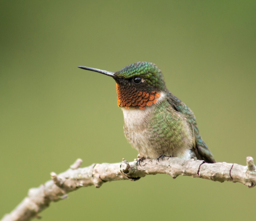

In [12]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

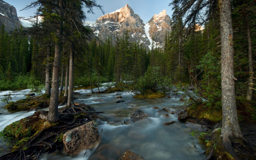

In [14]:
search_term = 'forest photos'
image_save = 'forest.jpg'
download_url(search_images(search_term, max_images=1)[0],image_save, show_progress=False)
Image.open(image_save).to_thumb(256,256)

In [16]:
# Download a set of images of birds and forests for training a model
searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  resize_images(path/o, max_size=400, dest=path/o)

# Train model

In [18]:
# remove failed downloads

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'There were {len(failed)} failed images')

There were 0 failed images


In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

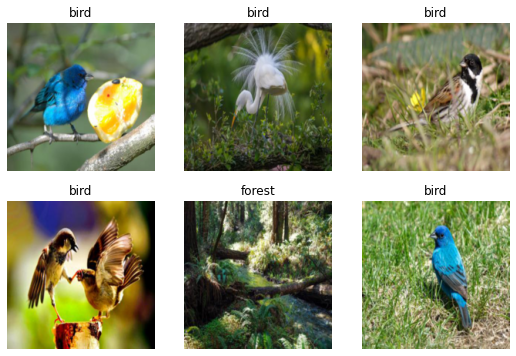

In [20]:
dls.show_batch(max_n=6)

Here what each of the DataBlock parameters means:  
_blocks=(ImageBlock, CategoryBlock),_  
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").  
  
_get_items=get_image_files,_  
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).  
  
_splitter=RandomSplitter(valid_pct=0.2, seed=42),_  
Split the data into training and validation sets randomly, using 20% of the data for the validation set.  
  
  _get_y=parent_label,_  
  The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).  
  
_item_tfms=[Resize(192, method='squish')]_  
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).  


## Now we're ready to train our model. The fastest widely used computer vision model is resnet18.

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.848846,0.526007,0.171053,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.059625,0.164183,0.052632,01:25
1,0.037412,0.066181,0.013158,01:03
2,0.027441,0.017500,0.013158,00:59
3,0.019876,0.007999,0.000000,01:00


In [23]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f'This is a" {is_bird}.')
print(f'Probability it is a bird: {probs[0]:.4f}')

This is a" bird.
Probability it is a bird: 1.0000


In [25]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
#device = get_default_device()      
print(f'device is {get_default_device}')

device is <function get_default_device at 0x7f5d8a85d830>
